
## Setup


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from mpl_toolkits.mplot3d import Axes3D


In [2]:
### EX1
def random_points_in_triangle(v1, v2, v3, n_points):
    points = []
    for _ in range(n_points):
        r1, r2 = np.random.rand(2)
        sqrt_r1 = np.sqrt(r1)
        point = (1 - sqrt_r1) * v1 + sqrt_r1 * (1 - r2) * v2 + sqrt_r1 * r2 * v3
        points.append(point)
    return np.array(points)

def generate_symmetric_triangles_data(K=3, N=100, random_state=42):
    np.random.seed(random_state)
    # Define vertices for three symmetric triangles
    side_length = 2
    height = np.sqrt(3) * side_length / 2
    triangles = [
        (np.array([0, 0]), np.array([side_length, 0]), np.array([side_length / 2, height])),
        (np.array([0, 0]), np.array([-side_length, 0]), np.array([-side_length / 2, height])),
        (np.array([0, 0]), np.array([1.5, -height]), np.array([-1.5, -height]))
    ]

    X, y = [], []
    for i, (v1, v2, v3) in enumerate(triangles):
        points = random_points_in_triangle(v1, v2, v3, N)
        X.append(points)
        y += [i] * N

    X = np.vstack(X)
    y = np.array(y)
    return X, y

### EX2
def generate_grid_data(grid_size=4, min_points=5, max_points=20, random_state=42):
    np.random.seed(random_state)
    X, y = [], []
    half_grid_size = grid_size // 2

    for i in range(grid_size):
        for j in range(grid_size):
            n_points = np.random.randint(min_points, max_points + 1)
            x_offset = i - half_grid_size + 0.5
            y_offset = j - half_grid_size + 0.5
            # Generate points more centered within the square
            points = 0.8 * (np.random.rand(n_points, 2) - 0.5) + [x_offset, y_offset]
            X.append(points)
            label = (i + j) % 2
            y += [label] * n_points

    X = np.vstack(X)
    y = np.array(y)
    return X, y

### EX3
def generate_concentric_circles_data(radii=[1, 2, 3, 4], points_per_circle=100, random_state=42):
    np.random.seed(random_state)
    X, y = [], []

    for i, radius in enumerate(radii):
        angles = np.linspace(0, 2 * np.pi, points_per_circle, endpoint=False)
        circle_x = radius * np.cos(angles) + np.random.normal(0, 0.1, points_per_circle)
        circle_y = radius * np.sin(angles) + np.random.normal(0, 0.1, points_per_circle)
        X.append(np.vstack((circle_x, circle_y)).T)
        y += [i] * points_per_circle

    X = np.vstack(X)
    y = np.array(y)
    return X, y

### EX4
def generate_nested_rectangles_data(inner_rect=(2, 1), middle_rect=(4, 2), outer_rect=(6, 3), points_per_rectangle=100, random_state=42):
    np.random.seed(random_state)
    X, y = [], []

    # Inner rectangle
    width, height = inner_rect
    x_points = width * (np.random.rand(points_per_rectangle) - 0.5)
    y_points = height * (np.random.rand(points_per_rectangle) - 0.5)
    X.append(np.vstack((x_points, y_points)).T)
    y += [0] * points_per_rectangle

    # Middle rectangle
    width, height = middle_rect
    x_points = width * (np.random.rand(points_per_rectangle) - 0.5)
    y_points = height * (np.random.rand(points_per_rectangle) - 0.5)
    # Exclude points that fall inside the inner rectangle
    mask = (np.abs(x_points) > inner_rect[0] / 2) | (np.abs(y_points) > inner_rect[1] / 2)
    X.append(np.vstack((x_points[mask], y_points[mask])).T)
    y += [1] * len(x_points[mask])

    # Outer rectangle
    width, height = outer_rect
    x_points = width * (np.random.rand(points_per_rectangle) - 0.5)
    y_points = height * (np.random.rand(points_per_rectangle) - 0.5)
    # Exclude points that fall inside the middle rectangle
    mask = (np.abs(x_points) > middle_rect[0] / 2) | (np.abs(y_points) > middle_rect[1] / 2)
    X.append(np.vstack((x_points[mask], y_points[mask])).T)
    y += [2] * len(x_points[mask])

    X = np.vstack(X)
    y = np.array(y)
    return X, y


def plot_data(X, y, title=""):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolor='k', s=50)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(title)
    plt.legend(handles=scatter.legend_elements()[0], labels=set(y), title="Classes")
    plt.show()



In [3]:
import torch
from torch import nn, optim
from tqdm.auto import tqdm
from torch.utils.data import DataLoader

In [4]:
def preproc(X, y):
  X_tnsr, y_tnsr = torch.Tensor(X), torch.Tensor(y).long()
  return X_tnsr, y_tnsr

In [5]:
def training(model, X, y, optimizer, criterion, num_epochs):

  model.train()
  losses = []

  for epoch in range(num_epochs):

    optimizer.zero_grad()

    y_pred = model(X)
    loss = criterion(y_pred, y)

    loss.backward()
    optimizer.step()

    losses.append(loss.item())

  return model, losses

In [6]:
def plot_decision_boundaries(model, X, y, accuracy):
    # Create a grid of points
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                         np.linspace(y_min, y_max, 500))

    # Flatten grid and convert to tensor
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    grid_tensor = torch.Tensor(grid_points)

    # Predict for each point in the grid
    with torch.no_grad():
        predictions = model(grid_tensor)
        predicted_classes = predictions.argmax(dim=1).numpy()

    # Reshape predictions to match the grid
    zz = predicted_classes.reshape(xx.shape)

    # Plot decision boundaries
    plt.contourf(xx, yy, zz, alpha=0.5, cmap=plt.cm.Paired)
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=plt.cm.Paired)
    #plt.legend(handles=scatter.legend_elements()[0], labels=set(y), title="Classes")
    plt.legend(handles=scatter.legend_elements()[0],
               labels=set(map(str, set(y))),  # Convert labels to strings
               title="Classes",
               loc="upper right")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("Decision Boundaries, accuracy = {:.3f}".format(accuracy))

    plt.show()

In [7]:
def plot_training_loss(losses, num_epochs):
  plt.plot(range(num_epochs), losses, label="Training Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title("Training Loss Over Epochs")
  plt.legend()
  plt.grid(True)
  plt.show()

In [8]:
def eval(model, X, y):
  with torch.no_grad():
    predictions = model(X)
    predicted_classes = predictions.argmax(dim=1).numpy()

  accuracy = (predicted_classes == y.numpy()).mean()
  return accuracy

## EX1

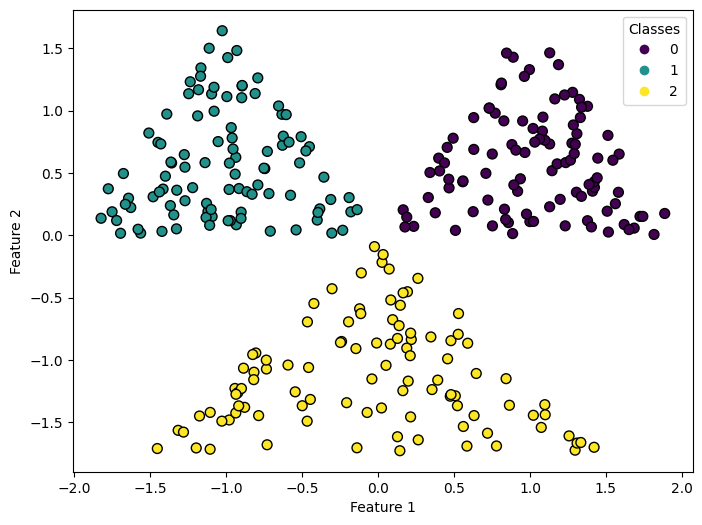

In [9]:
# Generate the data
X_train, y_train = generate_symmetric_triangles_data(random_state=0)
X_test, y_test = generate_symmetric_triangles_data(random_state=1)

# Plot the data
plot_data(X_train, y_train)

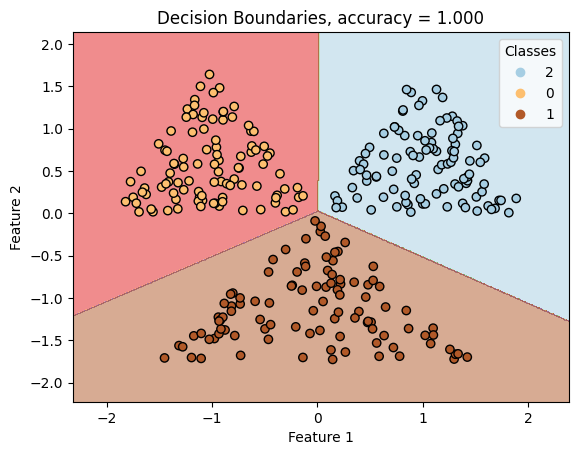

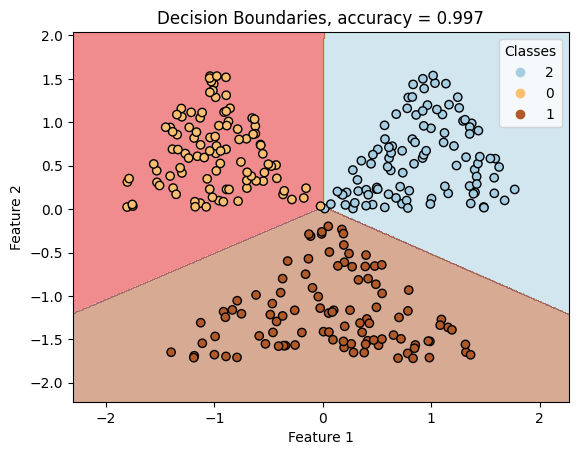

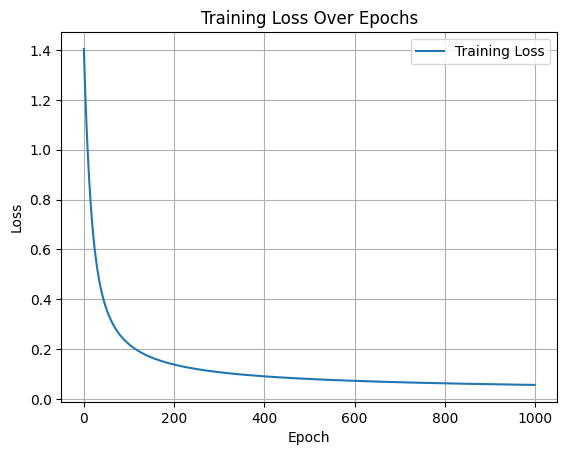

In [10]:
X_train_mod, y_train_mod = preproc(X_train, y_train)
X_test_mod, y_test_mod = preproc(X_test, y_test)

input_size = X_train.shape[1]
output_size = 3

ex1_model = nn.Sequential(nn.Linear(input_size, output_size),
                          nn.LogSoftmax(dim=1))

softmax_optimizer = optim.SGD(ex1_model.parameters(), lr=0.1, weight_decay=0.001)

criterion = nn.NLLLoss()

num_epochs = 1000

ex1_model_trained, losses = training(ex1_model, X_train_mod, y_train_mod, softmax_optimizer, criterion, num_epochs)

train_accuracy = eval(ex1_model_trained, X_train_mod, y_train_mod)

test_accuracy = eval(ex1_model_trained, X_test_mod, y_test_mod)

plot_decision_boundaries(ex1_model_trained, X_train_mod.numpy(), y_train_mod.numpy(), train_accuracy)

print("\n")

plot_decision_boundaries(ex1_model_trained, X_test_mod.numpy(), y_test_mod.numpy(), test_accuracy)

print("\n")

plot_training_loss(losses, num_epochs)


The model performed well due to its simplicity, as it uses a linear layer with a LogSoftmax activation. From previous attempts, we learned the importance of fine-tuning hyperparameters like learning rate and weight decay for better convergence.







## EX2

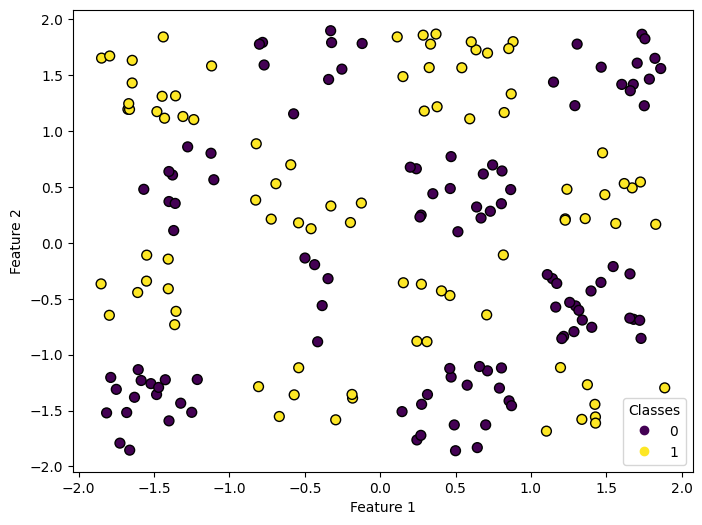

In [11]:
# Generate the data
X_train, y_train = generate_grid_data(random_state=0)
X_test, y_test = generate_grid_data(random_state=1)

# Plot the data
plot_data(X_train, y_train)

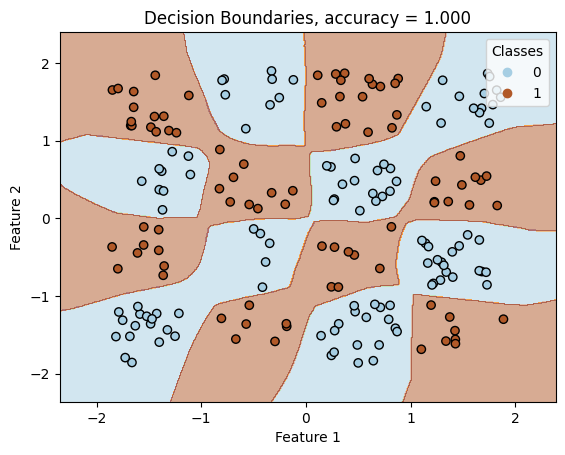

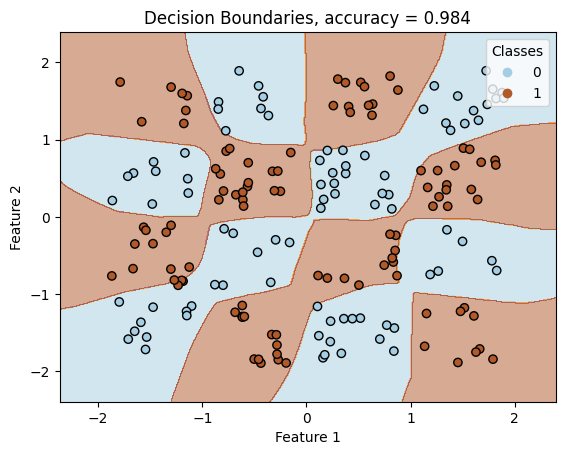

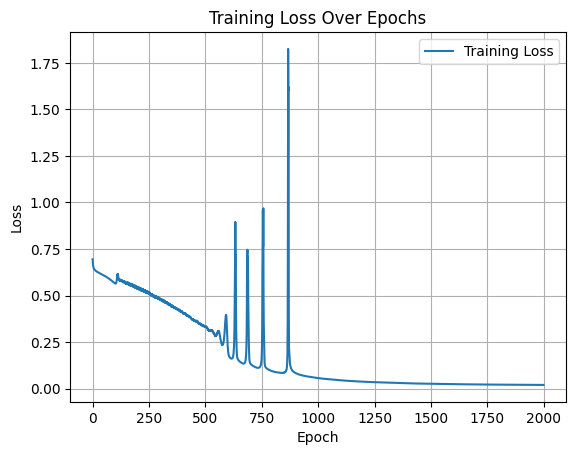

In [12]:
X_train_mod, y_train_mod = preproc(X_train, y_train)
X_test_mod, y_test_mod = preproc(X_test, y_test)

input_size = X_train.shape[1]
output_size = 2

hidden_size = 128

ex2_model = nn.Sequential(nn.Linear(input_size, hidden_size),
                      nn.ReLU(),
                      nn.Linear(hidden_size, hidden_size),
                      nn.ReLU(),
                      nn.Linear(hidden_size, output_size),
                      nn.LogSoftmax(dim=1))

mlp_optimizer = optim.SGD(ex2_model.parameters(), lr=0.2, weight_decay=0.001)

criterion = nn.NLLLoss()

num_epochs = 2000

ex2_model_trained, losses = training(ex2_model, X_train_mod, y_train_mod, mlp_optimizer, criterion, num_epochs)

train_accuracy = eval(ex2_model_trained, X_train_mod, y_train_mod)

test_accuracy = eval(ex2_model_trained, X_test_mod, y_test_mod)

plot_decision_boundaries(ex2_model_trained, X_train_mod.numpy(), y_train_mod.numpy(), train_accuracy)

print("\n")

plot_decision_boundaries(ex2_model_trained, X_test_mod.numpy(), y_test_mod.numpy(), test_accuracy)

print("\n")

plot_training_loss(losses, num_epochs)


The model leverages an MLP with two hidden layers of 128 neurons each and ReLU activations, enabling it to capture more complex patterns in the data compared to a simple linear model. From previous attempts, we learned that adding more layers and neurons can improve performance, but also requires careful tuning of the learning rate and regularization to prevent overfitting.







## EX3

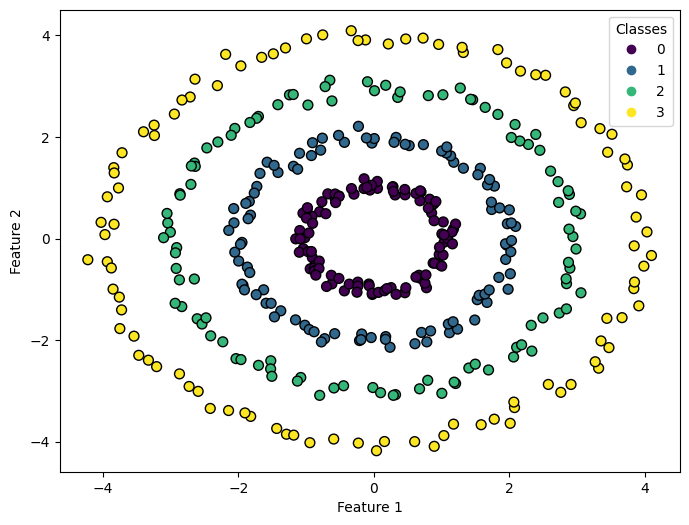

In [13]:
# Generate the data
X_train, y_train = generate_concentric_circles_data(random_state=0)
X_test, y_test = generate_concentric_circles_data(random_state=1)

# Plot the data
plot_data(X_train, y_train)


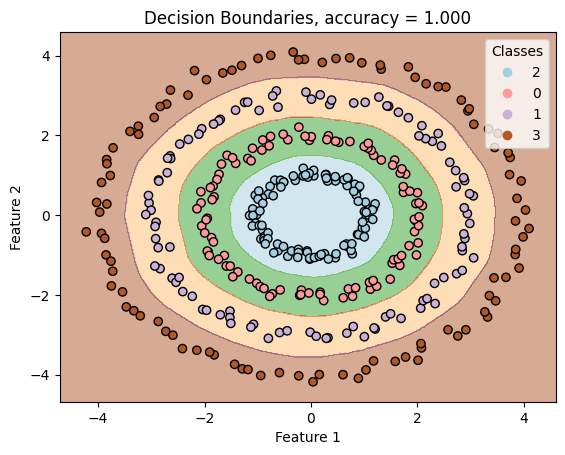

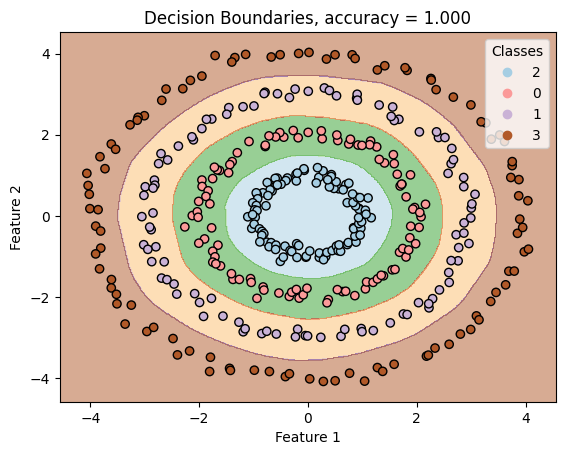

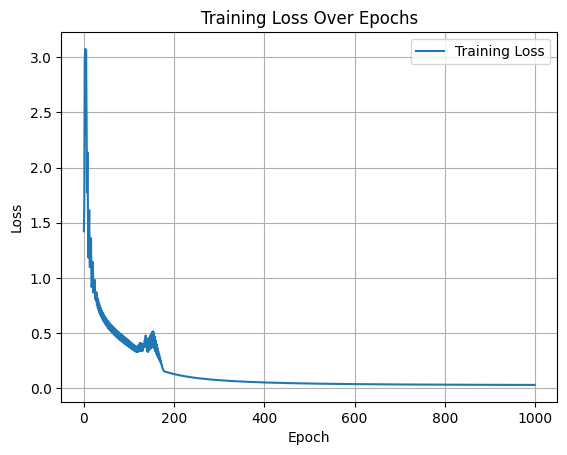

In [14]:
X_train_mod, y_train_mod = preproc(X_train, y_train)
X_test_mod, y_test_mod = preproc(X_test, y_test)

input_size = X_train.shape[1]
output_size = 4

hidden_size = 128

ex3_model = nn.Sequential(nn.Linear(input_size, hidden_size),
                      nn.ReLU(),
                      nn.Linear(hidden_size, output_size),
                      nn.LogSoftmax(dim=1))

mlp_optimizer = optim.SGD(ex3_model.parameters(), lr=0.5, weight_decay=0.001)

criterion = nn.NLLLoss()

num_epochs = 1000

ex3_model_trained, losses = training(ex3_model, X_train_mod, y_train_mod, mlp_optimizer, criterion, num_epochs)

train_accuracy = eval(ex3_model_trained, X_train_mod, y_train_mod)

test_accuracy = eval(ex3_model_trained, X_test_mod, y_test_mod)

plot_decision_boundaries(ex3_model_trained, X_train_mod.numpy(), y_train_mod.numpy(), train_accuracy)

print("\n")

plot_decision_boundaries(ex3_model_trained, X_test_mod.numpy(), y_test_mod.numpy(), test_accuracy)

print("\n")

plot_training_loss(losses, num_epochs)


This model uses an MLP with one hidden layer of 128 neurons and ReLU activation. The architecture balances simplicity and capacity to handle moderately complex data. Key design decisions included the choice of a single hidden layer for efficiency and a learning rate of 0.1 for steady convergence. From previous experiments, we observed that increasing the number of output classes can impact optimization.







## EX4

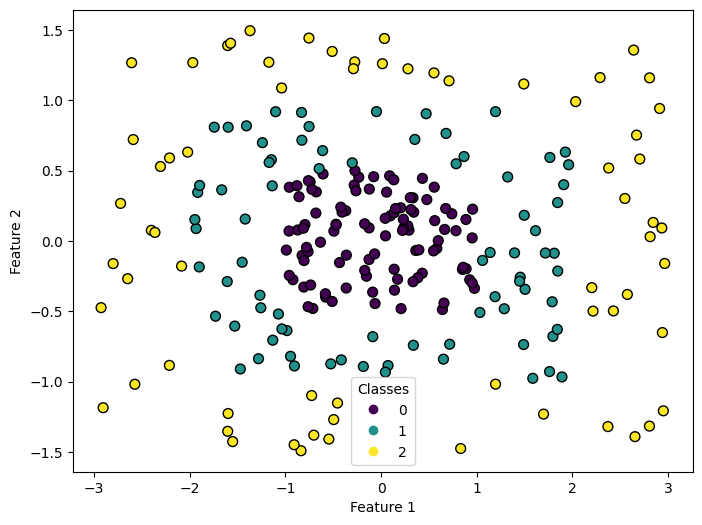

In [15]:
# Generate the data
X_train, y_train = generate_nested_rectangles_data(random_state=0)
X_test, y_test = generate_nested_rectangles_data(random_state=1)

# Plot the data
plot_data(X_train, y_train)

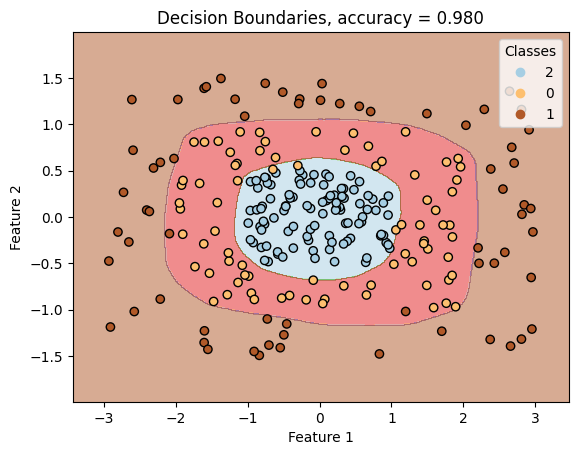

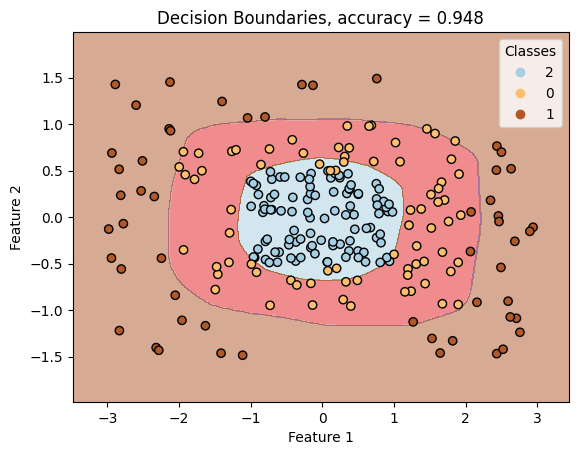

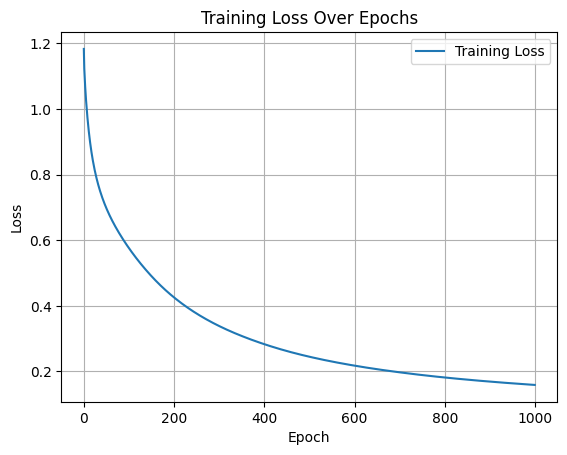

In [16]:
X_train_mod, y_train_mod = preproc(X_train, y_train)
X_test_mod, y_test_mod = preproc(X_test, y_test)

input_size = X_train.shape[1]
output_size = 3

hidden_size = 128

ex3_model = nn.Sequential(nn.Linear(input_size, hidden_size),
                      nn.ReLU(),
                      nn.Linear(hidden_size, output_size),
                      nn.LogSoftmax(dim=1))

mlp_optimizer = optim.SGD(ex3_model.parameters(), lr=0.1, weight_decay=0.001)

criterion = nn.NLLLoss()

num_epochs = 1000

ex3_model_trained, losses = training(ex3_model, X_train_mod, y_train_mod, mlp_optimizer, criterion, num_epochs)

train_accuracy = eval(ex3_model_trained, X_train_mod, y_train_mod)

test_accuracy = eval(ex3_model_trained, X_test_mod, y_test_mod)

plot_decision_boundaries(ex3_model_trained, X_train_mod.numpy(), y_train_mod.numpy(), train_accuracy)

print("\n")

plot_decision_boundaries(ex3_model_trained, X_test_mod.numpy(), y_test_mod.numpy(), test_accuracy)

print("\n")

plot_training_loss(losses, num_epochs)


This model employs an MLP with one hidden layer of 128 neurons and ReLU activation. A higher learning rate of 0.1 was used for steady convergence. The architecture reflects a balance between complexity and efficiency.



## EX5 - Mystery Dataset


In [18]:
X_train = np.load('X_train.npy', encoding='bytes')
X_test = np.load('X_test.npy', encoding='bytes')
y_train = np.load('y_train.npy', encoding='bytes')
y_test = np.load('y_test.npy', encoding='bytes')

In [19]:
print(X_train.shape)
print(len(set(y_train)))

(600, 5)
6


training accuracy =  0.9983333333333333
test accuracy =  0.9783333333333334




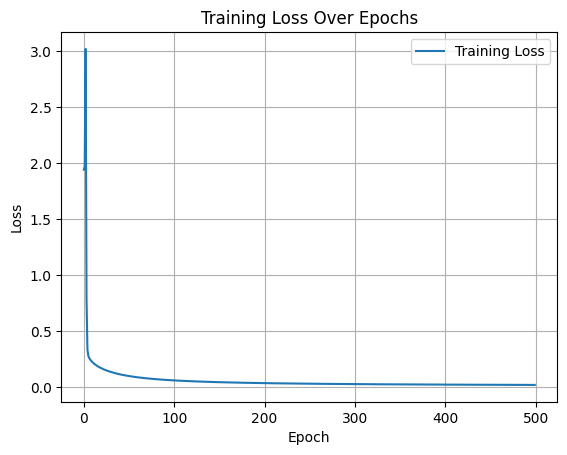

In [20]:
X_train_mod, y_train_mod = preproc(X_train, y_train)
X_test_mod, y_test_mod = preproc(X_test, y_test)

input_size = X_train.shape[1]
output_size = 6

hidden_size = 128

ex5_model = nn.Sequential(nn.Linear(input_size, hidden_size),
                      nn.ReLU(),
                      nn.Linear(hidden_size, output_size),
                      nn.LogSoftmax(dim=1))

mlp_optimizer = optim.SGD(ex5_model.parameters(), lr=0.2, weight_decay=0.001)

criterion = nn.NLLLoss()

num_epochs = 500

ex5_model_trained, losses = training(ex5_model, X_train_mod, y_train_mod, mlp_optimizer, criterion, num_epochs)

train_accuracy = eval(ex5_model_trained, X_train_mod, y_train_mod)

print("training accuracy = ", train_accuracy)

test_accuracy = eval(ex5_model_trained, X_test_mod, y_test_mod)

print("test accuracy = ", test_accuracy)

print("\n")

plot_training_loss(losses, num_epochs)


This model is an MLP with one hidden layer of 128 neurons and ReLU activation, designed for a six-class classification problem. The learning rate of 0.2 and training duration of 500 epochs were chosen to balance convergence speed and stability.






In [21]:
from sklearn.datasets import make_s_curve
### EX7
def generate_s_curve_data(n_samples=150, random_state=42):
    X, t = make_s_curve(n_samples, random_state=random_state)
    X = X[:, [0, 2]]  # Use only 2D input (X[:, 0] and X[:, 2])
    return X, t

def create_labels_s_curve(X, t):
    # Sort the indices based on the S-curve parameter t
    sorted_indices = np.argsort(t)
    labels = np.linspace(-1, 1, len(t))
    y = np.zeros_like(t)
    y[sorted_indices] = labels
    return y

def plot_s_curve(X, y, title='S-Curve'):
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolor='k', s=50)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(title)
    plt.colorbar(scatter, label='Label')
    plt.show()


### EX8
def generate_spiral_data(n_points=1000, n_turns=2.5, noise=0.05, random_state=42):
    np.random.seed(random_state)
    theta = np.linspace(0, n_turns * 2 * np.pi, n_points)
    r = np.linspace(0, 1, n_points)
    x = r * np.cos(theta) + noise * np.random.randn(n_points)
    y = r * np.sin(theta) + noise * np.random.randn(n_points)
    X = np.vstack((x, y)).T
    return X, theta

def create_labels_spiral(theta):
    labels = np.linspace(-1, 1, len(theta))
    return labels

def plot_spiral(X, y, title='Spiral'):
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolor='k', s=50)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(title)
    plt.colorbar(scatter, label='Label')
    plt.show()

### EX9
def generate_spiral_data_3d(n_points=1000, n_turns=2.5, noise=0.05, random_state=42):
    np.random.seed(random_state)
    theta = np.linspace(0, n_turns * 2 * np.pi, n_points)
    z = np.linspace(0, 1, n_points)
    r = z
    x = r * np.cos(theta) + noise * np.random.randn(n_points)
    y = r * np.sin(theta) + noise * np.random.randn(n_points)
    X = np.vstack((x, y, z)).T
    return X, theta

def create_labels_3d_spiral(theta):
    labels = np.linspace(-1, 1, len(theta))
    return labels

def plot_spiral_3d(X, y, title='3D Spiral'):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap='viridis', edgecolor='k')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_zlabel('Feature 3')
    ax.set_title(title)
    fig.colorbar(scatter, ax=ax, label='Label')
    plt.show()

In [22]:
def reg_preproc(X, y):
  X_tnsr, y_tnsr = torch.Tensor(X), torch.Tensor(y).float()
  y_tnsr = y_tnsr.view(-1, 1)
  return X_tnsr, y_tnsr

In [23]:
def reg_eval(model, X, y):
  predictions = model(X)

  mse_loss = nn.MSELoss()

  # Compute the loss
  accuracy = mse_loss(predictions, y)

  return accuracy.item()

In [24]:
def reg_plot(X, y, title=""):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolor='k', s=50)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(title)
    plt.colorbar()
    plt.show()

In [25]:
def reg_plot_3d(X, y, title):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap='viridis', edgecolor='k')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_zlabel('Feature 3')
    ax.set_title(title)
    fig.colorbar(scatter, ax=ax, label='Label')
    plt.show()

## EX6

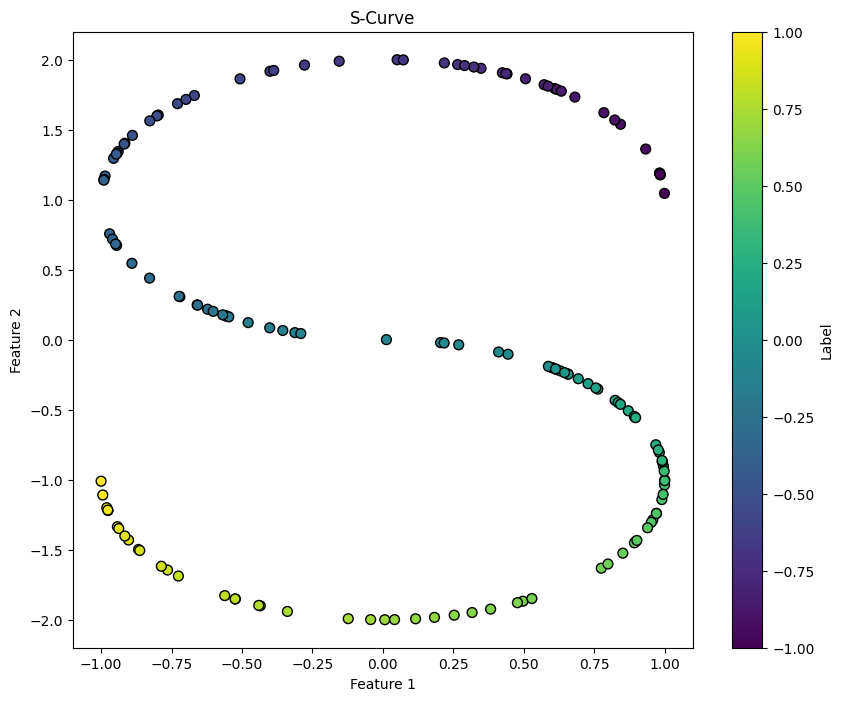

In [26]:
# Generate the data
X_train, theta_train = generate_s_curve_data(random_state=0)
X_test, theta_test = generate_s_curve_data(random_state=1)

# Create the labels
y_train = create_labels_s_curve(X_train, theta_train)
y_test = create_labels_s_curve(X_test, theta_test)

# Plot the data
plot_s_curve(X_train, y_train)

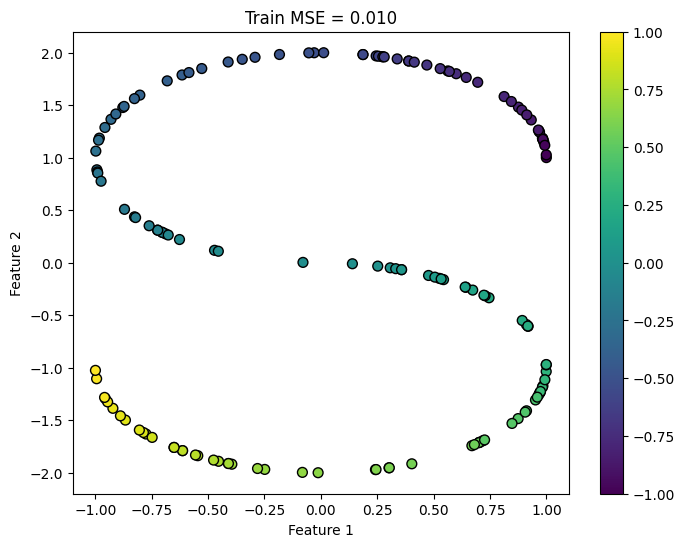

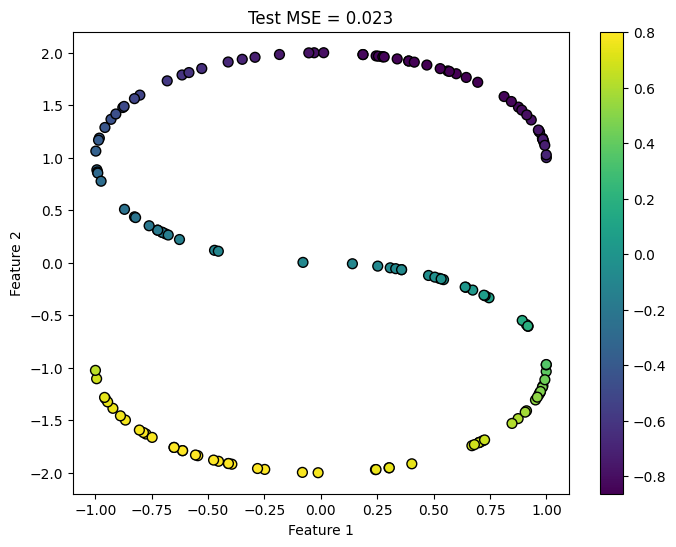

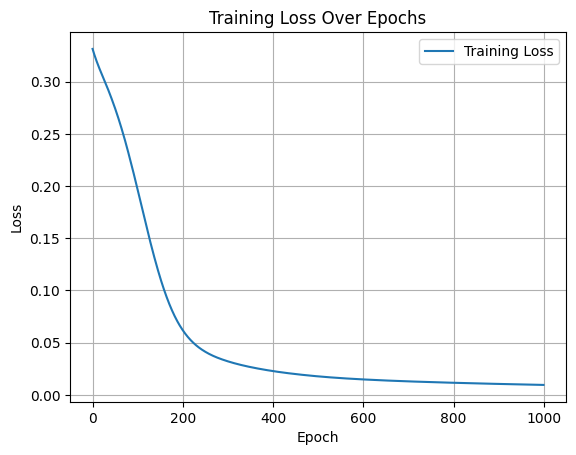

In [27]:
X_train_tensor, y_train_tensor = reg_preproc(X_train, y_train)
X_test_tensor, y_test_tensor = reg_preproc(X_test, y_test)

input_size = X_train.shape[1]
output_size = 1

hidden_size = 32

ex6_model = nn.Sequential(nn.Linear(input_size, hidden_size),
                          nn.ReLU(),
                          nn.Linear(hidden_size, hidden_size),
                          nn.ReLU(),
                          nn.Linear(hidden_size, hidden_size),
                          nn.ReLU(),
                          nn.Linear(hidden_size, output_size))

mlp_optimizer = optim.SGD(ex6_model.parameters(), lr=0.01, weight_decay=0.001)

criterion = nn.MSELoss()

num_epochs = 1000

ex6_model_trained, losses = training(ex6_model, X_train_tensor, y_train_tensor, mlp_optimizer, criterion, num_epochs)

train_accuracy = reg_eval(ex6_model_trained, X_train_tensor, y_train_tensor)

test_accuracy = reg_eval(ex6_model_trained, X_test_tensor, y_test_tensor)

with torch.no_grad():
  y_test_pred = ex6_model_trained(X_test_tensor)
  y_test_pred = y_test_pred.numpy()

reg_plot(X_test_tensor, y_test, title=f"Train MSE = {train_accuracy:.3f}")


print("\n")

reg_plot(X_test_tensor, y_test_pred, title=f"Test MSE = {test_accuracy:.3f}")

print("\n")

plot_training_loss(losses, num_epochs)


The model's performance depended on the ability of the three-layered architecture to capture the relationships in the data. The use of ReLU activation and multiple hidden layers (with 32 neurons each) aimed to enhance its capacity for learning complex patterns. However, the performance might be limited by the small hidden layer size or potential underfitting due to the relatively simple architecture and optimization with SGD. Hyperparameter choices like learning rate (0.01) and weight decay (0.001) also influenced convergence and generalization.

## EX7

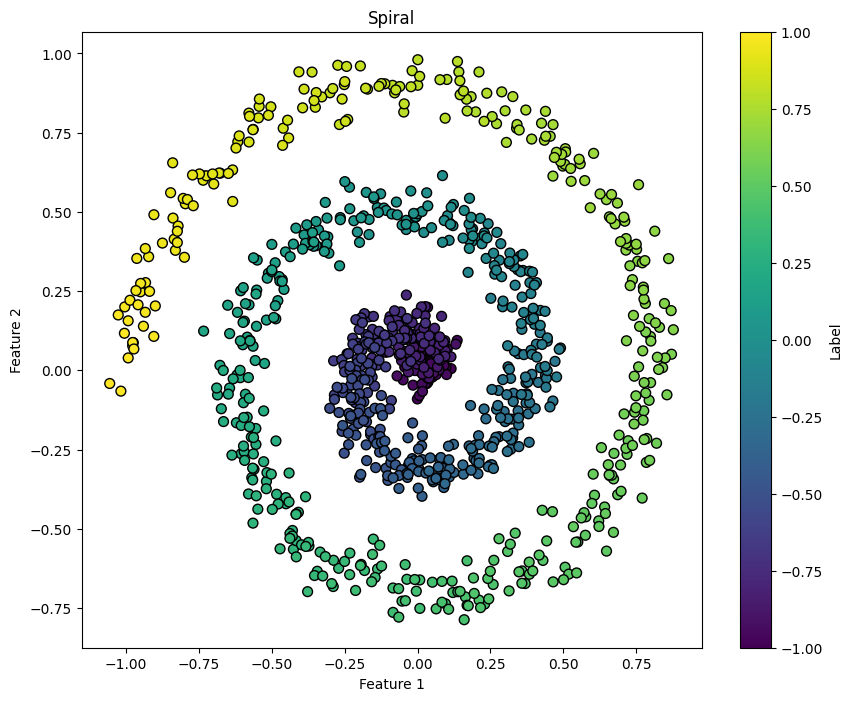

In [28]:
# Generate the data
X_train, theta_train = generate_spiral_data(random_state=0)
X_test, theta_test = generate_spiral_data(random_state=1)
# Create the labels
y_train = create_labels_spiral(theta_train)
y_test = create_labels_spiral(theta_test)
# Plot the data
plot_spiral(X_train, y_train)


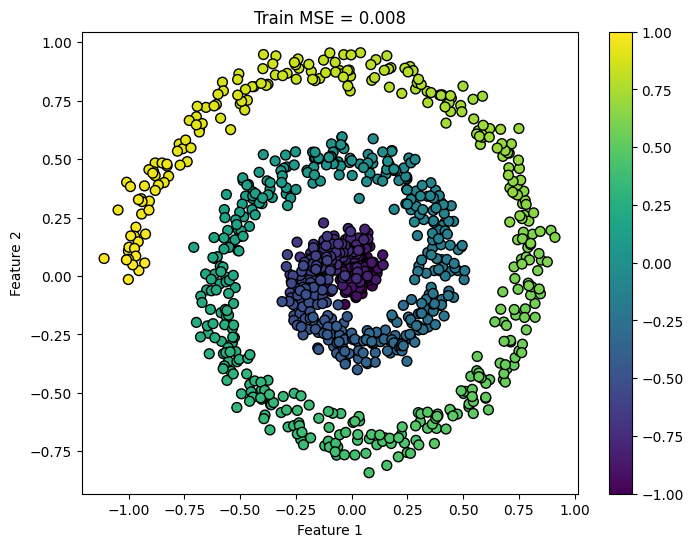

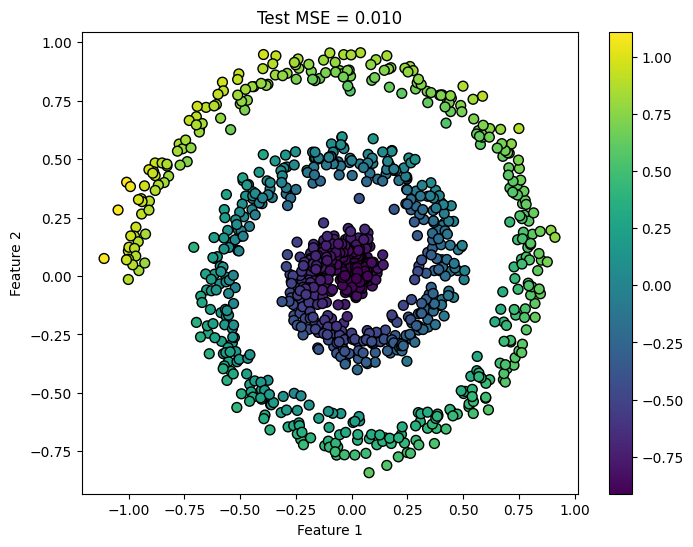

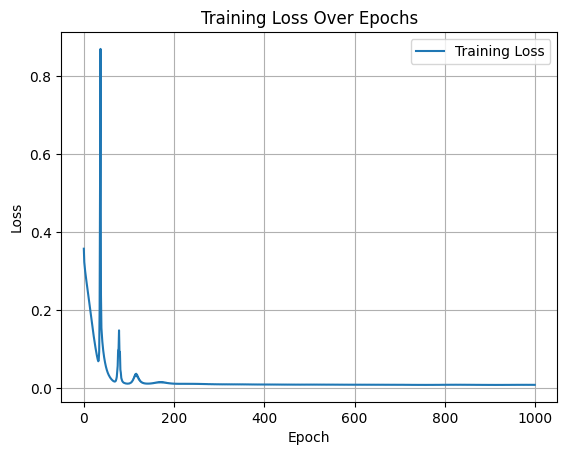

In [29]:
X_train_tensor, y_train_tensor = reg_preproc(X_train, y_train)
X_test_tensor, y_test_tensor = reg_preproc(X_test, y_test)

input_size = X_train.shape[1]
output_size = 1

hidden_size = 64

ex7_model = nn.Sequential(nn.Linear(input_size, hidden_size),
                          nn.ReLU(),
                          nn.Linear(hidden_size, hidden_size),
                          nn.ReLU(),
                          nn.Linear(hidden_size, output_size))

mlp_optimizer = optim.SGD(ex7_model.parameters(), lr=0.2, weight_decay=0.001)

criterion = nn.MSELoss()

num_epochs = 1000

ex7_model_trained, losses = training(ex7_model, X_train_tensor, y_train_tensor, mlp_optimizer, criterion, num_epochs)

train_accuracy = reg_eval(ex7_model_trained, X_train_tensor, y_train_tensor)

test_accuracy = reg_eval(ex7_model_trained, X_test_tensor, y_test_tensor)

with torch.no_grad():
  y_test_pred = ex7_model_trained(X_test_tensor)
  y_test_pred = y_test_pred.numpy()

reg_plot(X_test_tensor, y_test, title=f"Train MSE = {train_accuracy:.3f}")

print("\n")

reg_plot(X_test_tensor, y_test_pred, title=f"Test MSE = {test_accuracy:.3f}")

print("\n")

plot_training_loss(losses, num_epochs)



The model's performance was influenced by the larger hidden layer size (64 neurons), which provided more capacity to learn complex patterns in the data. The higher learning rate (0.2) allowed for faster convergence but may have caused instability during training, affecting performance. The reduced depth balanced complexity and computational cost.

## EX8

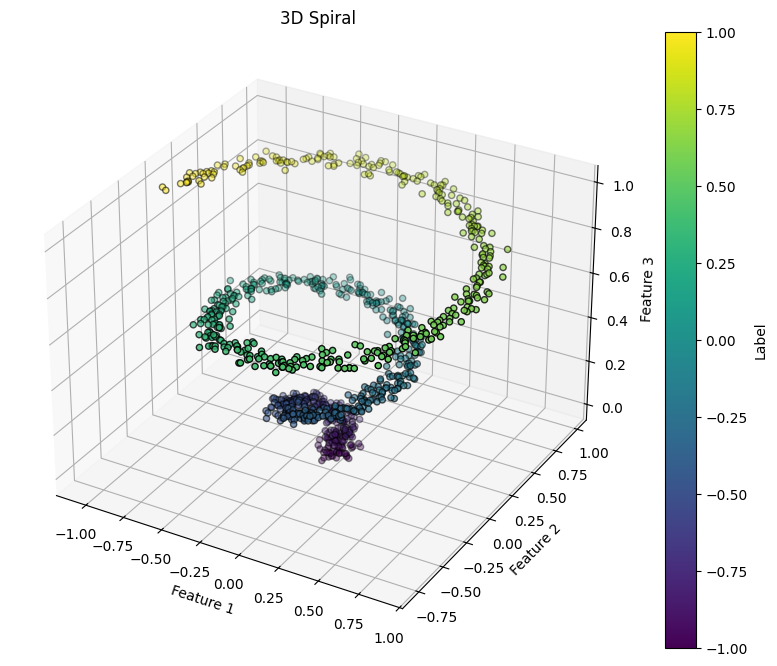

In [30]:
# Generate the data
X_train, theta_train = generate_spiral_data_3d(random_state=0)
X_test, theta_test = generate_spiral_data_3d(random_state=1)

# Create the labels
y_train = create_labels_3d_spiral(theta_train)
y_test = create_labels_3d_spiral(theta_test)

# Plot the data
plot_spiral_3d(X_train, y_train)

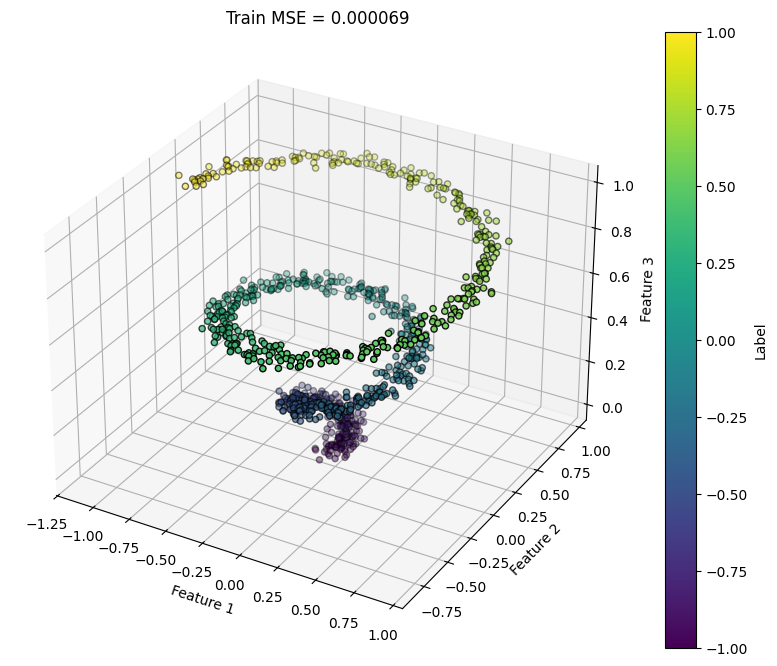

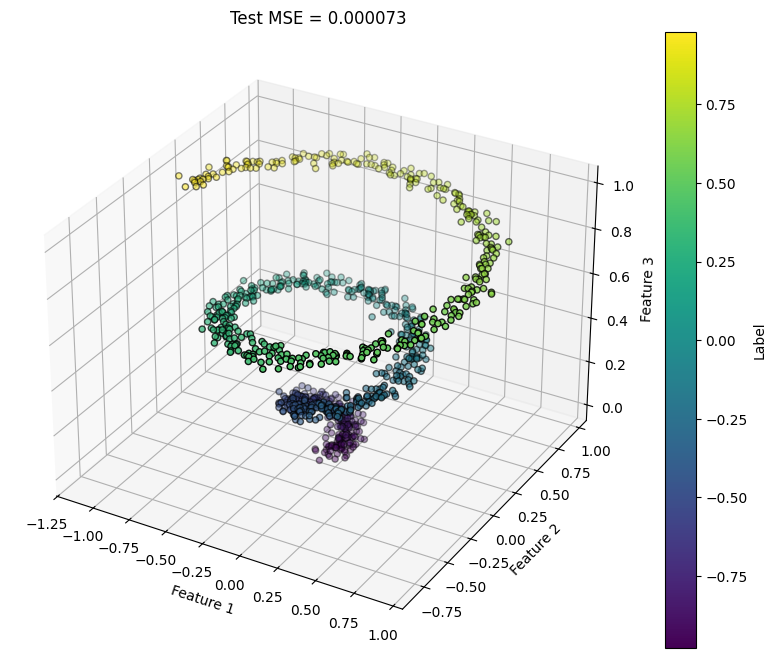

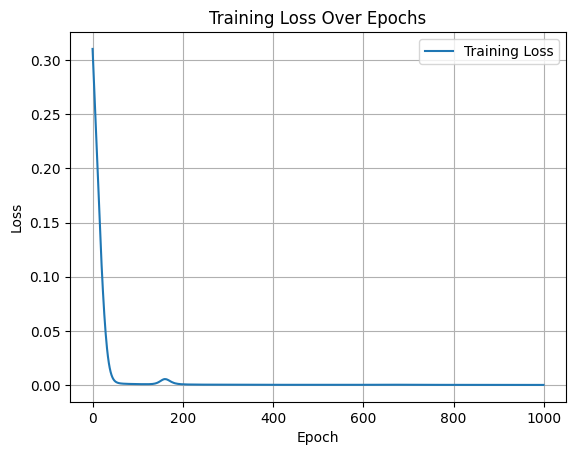

In [31]:
X_train_tensor, y_train_tensor = reg_preproc(X_train, y_train)
X_test_tensor, y_test_tensor = reg_preproc(X_test, y_test)

input_size = X_train.shape[1]
output_size = 1

hidden_size = 64

ex8_model = nn.Sequential(nn.Linear(input_size, hidden_size),
                          nn.ReLU(),
                          nn.Linear(hidden_size, hidden_size),
                          nn.ReLU(),
                          nn.Linear(hidden_size, output_size))

mlp_optimizer = optim.SGD(ex8_model.parameters(), lr=0.1, weight_decay=0.001)

criterion = nn.MSELoss()

num_epochs = 1000

ex8_model_trained, losses = training(ex8_model, X_train_tensor, y_train_tensor, mlp_optimizer, criterion, num_epochs)

train_accuracy = reg_eval(ex8_model_trained, X_train_tensor, y_train_tensor)

test_accuracy = reg_eval(ex8_model_trained, X_test_tensor, y_test_tensor)

with torch.no_grad():
  y_test_pred = ex8_model_trained(X_test_tensor)
  y_test_pred = y_test_pred.numpy()

reg_plot_3d(X_test_tensor, y_test, title=f"Train MSE = {train_accuracy:.6f}")

print("\n")

reg_plot_3d(X_test_tensor, y_test_pred, title=f"Test MSE = {test_accuracy:.6f}")

print("\n")

plot_training_loss(losses, num_epochs)



The model leveraged a balanced architecture with 64 neurons per layer and two hidden layers, which allowed it to capture moderately complex data patterns. A learning rate of 0.1 provided a balance between convergence speed and stability. The use of 3D visualizations highlighted the model's ability to approximate the target function but also revealed areas where performance could be refined. Further improvements could involve experimenting with deeper architectures or adaptive optimizers like Adam.(in this example, we showed the MSE 6 digits after decimal point to show its not absolute zero)

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim

def train_model(model, X_train, y_train, X_val, y_val, epochs=100, lr=0.01):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)

    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()

        outputs = model(X_train)
        loss = criterion(outputs, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            train_pred = outputs.argmax(dim=1)
            train_accuracy = (train_pred == y_train).float().mean().item()

        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_pred = val_outputs.argmax(dim=1)
            val_accuracy = (val_pred == y_val).float().mean().item()

        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")

    return model, train_accuracies, val_accuracies


In [33]:

import matplotlib.pyplot as plt

def plot_training_accuracy(train_accuracies, val_accuracies):
    plt.figure(figsize=(8, 6))
    plt.plot(train_accuracies, 'b-', label='Training Accuracy')
    plt.plot(val_accuracies, 'r-', label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Time')
    plt.grid(True)
    plt.legend()
    plt.show()


In [34]:

def evaluate_accuracy(model, X, y):

    model.eval()

    with torch.no_grad():
        outputs = model(X).squeeze()
        predicted = outputs.argmax(dim=1)


    correct = (predicted == y).sum().item()
    total = y.size(0)
    accuracy = correct / total

    return accuracy


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.01MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.09MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.28MB/s]


Epoch [10/35], Train Accuracy: 0.9523, Val Accuracy: 0.9605
Epoch [20/35], Train Accuracy: 0.9903, Val Accuracy: 0.9882
Epoch [30/35], Train Accuracy: 0.9933, Val Accuracy: 0.9909


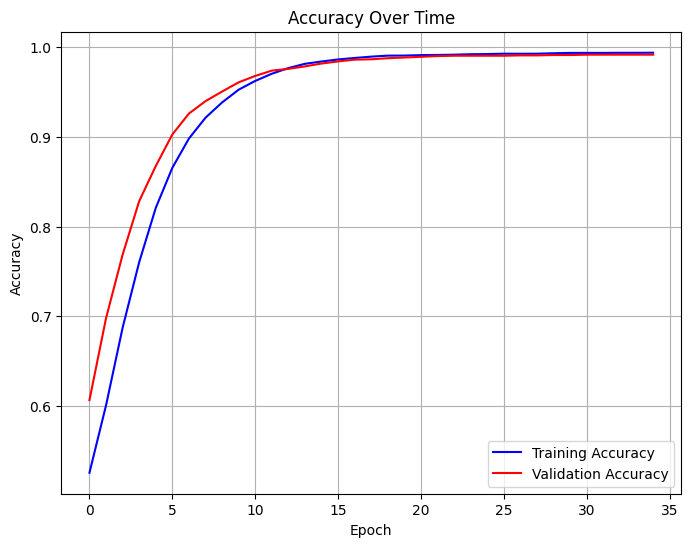

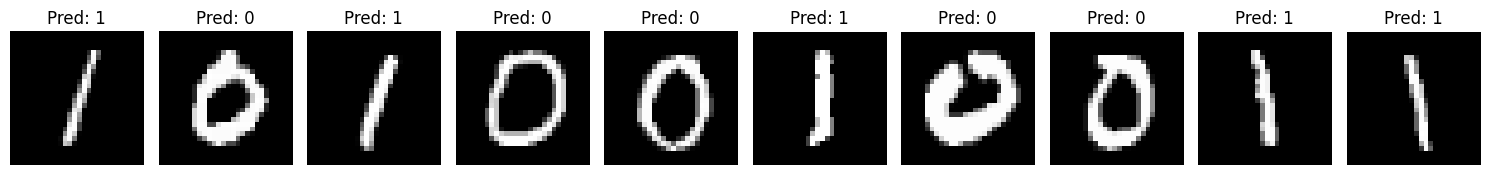

Test Accuracy: 1.00


In [35]:
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_data = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_data = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

digit1, digit2 = 0, 1

train_idx = (train_data.targets == digit1) | (train_data.targets == digit2)
test_idx = (test_data.targets == digit1) | (test_data.targets == digit2)

X_train = train_data.data[train_idx].float().unsqueeze(1) / 255.0
y_train = (train_data.targets[train_idx] == digit2).long()

X_test = test_data.data[test_idx].float().unsqueeze(1) / 255.0
y_test = (test_data.targets[test_idx] == digit2).long()

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)



input_size = 28 * 28
hidden_size = 128
output_size = 2

mlp_model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(input_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, output_size),
)


X_train = X_train.view(X_train.size(0), -1)
X_val = X_val.view(X_val.size(0), -1)
X_test = X_test.view(X_test.size(0), -1)

trained_model, train_accuracies, val_accuracies = train_model(mlp_model, X_train, y_train, X_val, y_val, epochs=35, lr=0.01)

plot_training_accuracy(train_accuracies, val_accuracies)

test_outputs = trained_model(X_test)
predicted_labels = test_outputs.argmax(dim=1)

fig, axes = plt.subplots(1, 10, figsize=(15, 4))

for i in range(10):
  image = X_test[i].view(28, 28)
  axes[i].imshow(image, cmap='gray')
  axes[i].set_title(f"Pred: {predicted_labels[i].item()}")
  axes[i].axis('off')

plt.tight_layout()
plt.show()

test_acc = evaluate_accuracy(trained_model, X_test, y_test)
print(f"Test Accuracy: {test_acc:.2f}")


## **Hyperparameters**:
MLP:
Suitable because MNIST data is relatively simple, especially for distinguishing just two digits.

Number of layers, number of neurons/kernels, kernel size:
1 fully connected layer with 128 neurons. More layers or neurons may overfit the small task.

Number of epochs
35 epochs was sufficient.
Over 50 epochs lead to diminishing returns or overfitting for this simple binary classification task.

Learning rate:
0.01: adjusted based on performance.

Loss function:
Binary Crossentropy: Standard for binary classification.

Activation function:
ReLU- Use in the hidden layer for efficient training and to avoid vanishing gradients.


### **Results** ###

**Convergence**: The model converged effectively, as indicated by the high validation and test accuracies (~99%+).

**Overfitting**: There is no overfitting in the accuracy curves since validation accuracy closely follows training accuracy throughout training.

**Image Classification Challenges**: Unlike toy examples, image classification requires handling high-dimensional input data (28x28 pixels) and capturing spatial relationships.

**First Impressions**: The task demonstrates how even a simple MLP can perform well on binary classification of MNIST digits, because of the inherent simplicity of the data.